In [1]:
import json
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import scipy
from plotnine import *
import plotnine
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig

### Load in sentence contexts for compounds and blends

In [2]:
sentences = pd.read_csv("./data/smoothie_sentence_contexts.tsv", sep="\t")
sentences = sentences.rename(columns={"Word": "word", "Category": "class"})
sentences['class'] = sentences['class'].replace(
    {"compound comp": "transparent compound",
     "compound new": "opaque compound"})
sentences.head()

,word,class,fold,sentence
0,homomorphism,domain,0,He also taught mathematics at the University o...
1,squatto,dialect,1,— yet aside from a few body-con dresses buried...
2,melanated,deriv,2,Can You Fix It?We’ve got answers.Credit...Moni...
3,melanated,deriv,2,Self-tanner delivers that extra-melanated look...
4,almondesque,affix,3,"Over time, the noyaux impart their heavenly ch..."


In [3]:
bases = pd.read_csv("./data/smoothies_folds.tsv", sep="\t")
bases['word'] = bases['source'].apply(lambda x: ''.join(x.split(" ")))
bases['word'] = bases['word'].replace({"colormetric": "colorimetric",
                                       "mythrealism": "mythorealism",
                                       "dramatherapy": "dramatotherapy",
                                       "cryptomine": "cryptomining"})
bases.head()

,#,source,fold0,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,word
0,1,batch code,batode,bate,batche,batcode,batode,bate,batche,batche,batche,batchode,batchcode
1,2,block holding,blolding,blolding,blooding,bloolding,blooding,blolding,blolding,blolding,blolding,blooding,blockholding
2,3,blood fruit,bloruit,blouit,blouit,bloruit,bloruit,bloruit,bloruit,bloruit,blouit,bloruit,bloodfruit
3,4,body hacking,bocking,bocking,bocking,backing,bocking,bocking,bocking,backing,bocking,bocking,bodyhacking
4,5,body snatched,boatched,boatched,botched,boatched,boatched,boatched,boatched,boatched,boatched,boatched,bodysnatched


In [4]:
gold_bases = pd.read_csv("./complex_words.tsv", sep="\t")
gold_bases.head()

,class,word,bases,sequence,linearity,semantic relation
0,blend,adhocrat,adhoc aristocrat,AAAAXBBB,linear,time
1,blend,ambidancetrous,ambidextrous dance,AAAAXBBBBAAAAA,nonlinear,attribute
2,blend,analingus,anal cunnilingus,AAAXBBBBB,linear,loc_part_whole
3,blend,aquamation,aqua cremation,AAAABBBBBB,linear,causal
4,blend,artveillance,art surveillance,AAABBBBBBBBB,linear,purpose


In [5]:
bases_long = bases.melt(id_vars=['word', "#", 'source']).rename(columns={'variable': 'no', 'value': 'smoothie'})
bases_long.head()

,word,#,source,no,smoothie
0,batchcode,1,batch code,fold0,batode
1,blockholding,2,block holding,fold0,blolding
2,bloodfruit,3,blood fruit,fold0,bloruit
3,bodyhacking,4,body hacking,fold0,bocking
4,bodysnatched,5,body snatched,fold0,boatched


In [6]:
bases_long = gold_bases.merge(bases_long, on='word', how='left').sort_values('smoothie')
bases_long.head()

,class,word,bases,sequence,linearity,semantic relation,#,source,no,smoothie
1361,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold9,astronk
1354,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold2,astronk
1358,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold6,astronk
1352,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold0,astrunk
1353,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold1,astrunk


In [7]:
len(sentences[['word', 'class']].iloc[np.where(sentences['class'].apply(
    lambda x: x in {'blend', 'transparent compound', 'opaque compound'}))].drop_duplicates().merge(
    bases_long[['word', 'class']].drop_duplicates(), how='left'))

312

In [8]:
sentences[['word', 'class']].iloc[np.where(sentences['class'].apply(
    lambda x: x in {'blend', 'transparent compound', 'opaque compound'}))].drop_duplicates().merge(
    bases_long[['word', 'semantic relation', 'class']].drop_duplicates(), how='left').groupby(
    ['class', 'semantic relation']).aggregate('count')

word
class                semantic relation      
blend                attribute            55
                     causal               15
                     cause                 4
                     containment           6
                     loc_part_whole       11
                     objective             1
                     other                 1
                     owner_emp_use         9
                     purpose              15
                     time                  8
                     topical              14
opaque compound      attribute            12
                     cause                 4
                     complement            1
                     containment           7
                     loc_part_whole       10
                     objective             2
                     other                 1
                     owner_emp_use         2
                     purpose               4
                     time                  1
                     topical               5
transparent compound attribute            25
                     causal               16
                     cause                 6
                     complement            1
                     containment          11
                     loc_part_whole       22
                     objective            11
                     other                 3
                     owner_emp_use         2
                     purpose               8
                     time                  1
                     topical              12

In [9]:
sentences_w_smoothies = bases_long.merge(sentences, how='left')
sentences_w_smoothies.head()

,class,word,bases,sequence,linearity,semantic relation,#,source,no,smoothie,fold,sentence
0,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold9,astronk,3.0,"These repurposed objects of beauty, in warrior..."
1,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold2,astronk,3.0,"These repurposed objects of beauty, in warrior..."
2,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold6,astronk,3.0,"These repurposed objects of beauty, in warrior..."
3,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold0,astrunk,3.0,"These repurposed objects of beauty, in warrior..."
4,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold1,astrunk,3.0,"These repurposed objects of beauty, in warrior..."


In [10]:
bases_replaced_sentences = []
smoothie_replaced_sentences = []
for i, row in sentences_w_smoothies.iterrows():
    sentence = row['sentence']
    neo = row['word']
    # this does not have smoothies
    category = row['class']
    if category=='blend':
        faux_neo = row['word']
    else:
        faux_neo = row['smoothie']
    if (category!='blend' and type(faux_neo) is not float) or (category=='blend'):
        morphemes = row['bases']
        if type(sentence) is float:
            sentence = ''
        else:
            sentence_ = sentence.lower().replace(neo, faux_neo)
            sentence_ = sentence.lower()
        smoothie_replaced_sentences.append(sentence_)
        sentence__ = sentence.lower().replace(neo, morphemes)
        bases_replaced_sentences.append(sentence__)
    else:
        print(neo)
        bases_replaced_sentences.append('')
        smoothie_replaced_sentences.append('')
sentences_w_smoothies['bases_replaced_sentence'] = bases_replaced_sentences
sentences_w_smoothies['smoothie_replaced_sentence'] = smoothie_replaced_sentences

In [11]:
sentences_w_smoothies['sentence_lower'] = sentences_w_smoothies['sentence'].str.lower()

In [12]:
len(sentences_w_smoothies.drop_duplicates()), len(sentences_w_smoothies), len(sentences_w_smoothies[
    ['sentence_lower', 'bases_replaced_sentence', 'smoothie_replaced_sentence',
     'class', 'word', 'smoothie', 'bases']].drop_duplicates())

(2544, 2544, 980)

In [13]:
sentences_w_smoothies.head()

,class,word,bases,sequence,linearity,semantic relation,#,source,no,smoothie,fold,sentence,bases_replaced_sentence,smoothie_replaced_sentence,sentence_lower
0,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold9,astronk,3.0,"These repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior..."
1,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold2,astronk,3.0,"These repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior..."
2,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold6,astronk,3.0,"These repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior..."
3,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold0,astrunk,3.0,"These repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior..."
4,opaque compound,astrofunk,astro funk,AAAAABBBB,linear,attribute,122.0,astro funk,fold1,astrunk,3.0,"These repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior..."


In [14]:
sentences_w_smoothies = sentences_w_smoothies[
    ['sentence_lower', 'bases_replaced_sentence', 'smoothie_replaced_sentence',
     'class', 'word', 'smoothie', 'bases']].drop_duplicates().reset_index(drop=True)

In [15]:
sentences_w_smoothies.head()

,sentence_lower,bases_replaced_sentence,smoothie_replaced_sentence,class,word,smoothie,bases
0,"these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...",opaque compound,astrofunk,astronk,astro funk
1,"these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...","these repurposed objects of beauty, in warrior...",opaque compound,astrofunk,astrunk,astro funk
2,"many have mixed ash, hair or other material wi...","many have mixed ash, hair or other material wi...","many have mixed ash, hair or other material wi...",transparent compound,bodyhacking,backing,body hack
3,the company said it would replace the affected...,the company said it would replace the affected...,the company said it would replace the affected...,transparent compound,batchcode,batche,batch code
4,the batchcode is on the bottom right of the la...,the batch code is on the bottom right of the l...,the batchcode is on the bottom right of the la...,transparent compound,batchcode,batche,batch code


## Embed blended/smoothied sentences and decomposed in BERT

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
model = BertModel.from_pretrained('bert-base-uncased', config=config)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [17]:
cos = torch.nn.modules.distance.CosineSimilarity(dim=-1)

In [18]:
vectors = []
with torch.no_grad():
    for i, row in sentences_w_smoothies.iterrows():
        word = row['word']
        x = row['bases_replaced_sentence']
        if type(x) is float:
            x = ''
            x = x.lower()
            print(word)
        y = row['smoothie_replaced_sentence'].lower()
        category = row['class']
        input_ids_x = torch.tensor([tokenizer.encode(x, add_special_tokens=True)])
        input_ids_y = torch.tensor([tokenizer.encode(y, add_special_tokens=True)])
        output_x = model(input_ids_x)
        output_y = model(input_ids_y)
        vectors.append((output_x, input_ids_x, x, output_y, input_ids_y, y, category))

In [19]:
simz = []
try:
    for i, record in enumerate(vectors):
        # original and substituted
        v_o, tok_ids_o, sent_o, v_s, tok_ids_s, sent_s, category = record
        tokenized_o = tokenizer.tokenize(sent_o)
        tokenized_s = tokenizer.tokenize(sent_s)
        row = sentences_w_smoothies.iloc[i]
        category = row['class']
        neo, neo_bpe = row['bases'], tokenizer.tokenize(row['bases'])
        if category=='blend':
            blends, neo_unblend_bpe = row['word'], tokenizer.tokenize(row['word'])
        elif category=='transparent compound' or category=='opaque compound':
            blends, neo_unblend_bpe = row['smoothie'], tokenizer.tokenize(row['smoothie'])
        len_neo, len_unblend = len(neo_bpe), len(neo_unblend_bpe)
        layers_o = v_o[2]
        layers_s = v_s[2]
        pos_indices = []
        for ix, w in enumerate(tokenized_o):
            tmp_indices = []
            if w==neo_bpe[0]:
                # compare arrays
                good = True
                for iy, w_ in enumerate(neo_bpe):
                    if ((ix + iy) < (len(tokenized_o) - 1)):
                        good = good * tokenized_o[ix + iy]==w_
                    else:
                        good = False
                if good:
                    for iy, w_ in enumerate(neo_bpe):
                        tmp_indices.append(ix + iy)
            if tmp_indices!=[]:
                pos_indices.append(tmp_indices)
        neg_indices = []
        for ix, w in enumerate(tokenized_s):
            tmp_indices = []
            if w==neo_unblend_bpe[0]:
                # compare arrays
                good = True
                for iy, w_ in enumerate(neo_unblend_bpe):
                    if ((ix + iy) < (len(tokenized_s) - 1)):
                        good = good * tokenized_s[ix + iy]==w_
                    else:
                        good = False
                if good:
                    for iy, w_ in enumerate(neo_unblend_bpe):
                        tmp_indices.append(ix + iy)
            if tmp_indices!=[]:
                neg_indices.append(tmp_indices)
        if pos_indices!=[] and neg_indices!=[]:
            for j, layer_o in enumerate(layers_o):
                layer_s = layers_s[j]
                for k, rec in enumerate(pos_indices):
                    vs = [layer_o[:, x, :] for x in rec]
                    vs = torch.stack(vs, dim=0).sum(dim=0).sum(dim=0)
                    try:
                        drec = neg_indices[k]
                    except IndexError:
                        pass
                    dvs = [layer_s[:, x, :] for x in drec]
                    dvs = torch.stack(dvs, dim=0).sum(dim=0).sum(dim=0)
                a = cos(vs.flatten(), dvs.flatten()).item()
                neo = row['word']
                simz.append([neo, i, j, a, category, sent_o])
except:
    print(row)

In [20]:
simz_df = pd.DataFrame(simz, columns=['word', 'vec_ix', 'layer', 'sim', 'class', 'sentence'])

wordform, type (blend/cc/cn), semantic label, similarity-per-layer

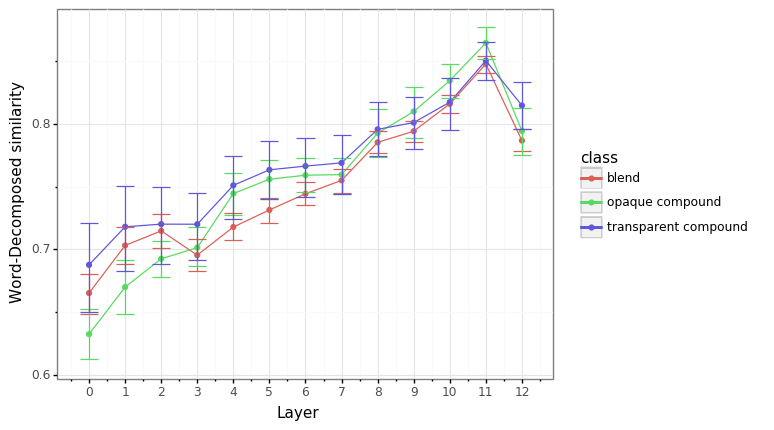

<ggplot: (323682473)>

In [21]:
(ggplot(simz_df.merge(sentences_w_smoothies),
       aes(x='layer', y='sim', color='class'))
 + stat_summary(geom='point') + stat_summary(geom='line')
 + stat_summary(geom='errorbar')
 + theme_bw()
 + scale_x_continuous(name="Layer", breaks=list(range(13)))
 + ylab("Word-Decomposed similarity"))

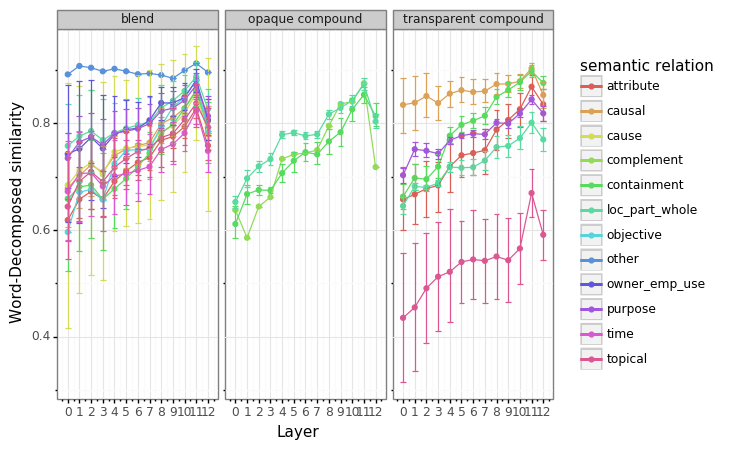

<ggplot: (-9223372036146714382)>

In [22]:
(ggplot(simz_df.merge(bases_long),
       aes(x='layer', y='sim', color='semantic relation'))
  + stat_summary(geom='point') + stat_summary(geom='line')
 + stat_summary(geom='errorbar')
 + theme_bw()
 + scale_x_continuous(name="Layer", breaks=list(range(13)))
 + ylab("Word-Decomposed similarity")
 + facet_wrap("~class"))

In [23]:
simz_df.to_csv("./smoothie_layer_sims.tsv", sep="\t", index=None)